<a href="https://colab.research.google.com/github/qasimb03/cs_4375_project/blob/main/CS_4375_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 4375 Project
### Professor Anurag Nagar
### Qasim Bhutta, Camden Alpert, Omar Hussain, Mauricio Rodriguez Rios

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
#Dataset import

url = 'https://raw.githubusercontent.com/qasimb03/cs_4375_project/refs/heads/main/austin_weather.csv'
weather_df = pd.read_csv(url)

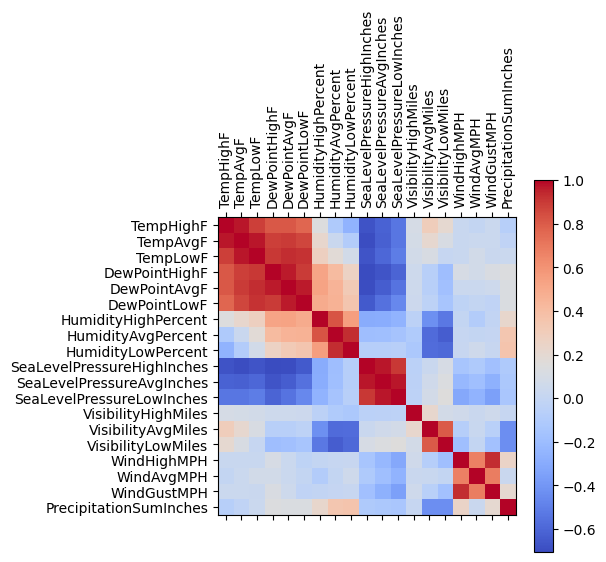

In [ ]:
# Preprocess Data
'''
Column Names:
'Date', 'TempHighF', 'TempAvgF', 'TempLowF', 'DewPointHighF',
'DewPointAvgF', 'DewPointLowF', 'HumidityHighPercent', 'HumidityAvgPercent',
'HumidityLowPercent', 'SeaLevelPressureHighInches', 'SeaLevelPressureAvgInches',
'SeaLevelPressureLowInches', 'VisibilityHighMiles', 'VisibilityAvgMiles', 'VisibilityLowMiles',
'WindHighMPH', 'WindAvgMPH', 'WindGustMPH', 'PrecipitationSumInches', 'Events'
'''
'''
Preprocessing Steps:
- Normalize/Scale data
- Split & Reshape into 3D Shape: [samples, time_steps, features] (for RNN support)
- Create Lagged Sequences (for RNN support)
'''

# Can either encode or drop Events => dropping for now
weather_df = weather_df.drop(columns=['Events', 'Date'])

# Replace 'T' with a small value (e.g., 0.001) or zero -- apparently T stands for Trace amounts of precipitation so a small number is sufficient
weather_df['PrecipitationSumInches'] = weather_df['PrecipitationSumInches'].replace('T', 0.001).astype(float)

# Replace '-' with NaN across the DataFrame
weather_df.replace('-', np.nan, inplace=True)
weather_df.dropna()

# See correlation to see which features best to use for target
plt.matshow(weather_df.corr(), cmap="coolwarm")
plt.colorbar()
plt.xticks(ticks=range(weather_df.shape[1]), labels=weather_df.columns, rotation=90)  # Rotate for readability
plt.yticks(ticks=range(weather_df.shape[1]), labels=weather_df.columns)
plt.show()

# Scale features
target_cols = ['TempAvgF']

feature_cols = weather_df[['TempAvgF', 'TempLowF', 'TempHighF']] #right now, start with tempavgF, temphighF, templowF as feature and tempavgf as target
standardScaler = StandardScaler()
scaled_features = standardScaler.fit_transform(feature_cols) #scale features
scaled_features_df = pd.DataFrame(scaled_features, columns=feature_cols.columns)
target_df = weather_df[target_cols]

weather_df_scaled = scaled_features_df

In [ ]:
# Reshape the df for RNN
def reshape_for_rnn(df, time_steps=7): #7 day sequence
    data = df.values  # Convert DataFrame to numpy array
    samples, features = data.shape

    # Calculate the number of sequences we can generate
    sequences = samples - time_steps + 1

    # Initialize an empty array for reshaping
    reshaped_data = np.zeros((sequences, time_steps, features))

    # Create sequences by sliding the window across the data
    for i in range(sequences):
        reshaped_data[i] = data[i:i + time_steps]

    return reshaped_data

weather_rnn = reshape_for_rnn(weather_df_scaled)

In [ ]:
def create_feature_target_arrays(data):
    X, y = [], []
    for i in range(len(data)-1): #We stop 1 short because the division is not even, so although 1313 sequences, 1312 in X, with 1312's target being 1313's first element
        X.append(data[i])
        y.append(data[i+1][0][0]) # first value in next sequence's first time step = target

    return np.array(X), np.array(y)

In [ ]:
# Split data into train and test datasets
train_data, test_data = train_test_split(weather_rnn, test_size=0.2, shuffle=False)
validation_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)

X_train, y_train = create_feature_target_arrays(train_data)
X_validation, y_validation = create_feature_target_arrays(validation_data)
X_test, y_test = create_feature_target_arrays(test_data)


In [ ]:
# Build Recurrent Neural Network
class RNN:
  def __init__(self, input_size, hidden_size, output_size, lr = 1e-3):

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    np.random.seed(20)
    self.input_weight = np.random.randn(self.input_size, self.hidden_size) * 0.001
    self.hidden_weight = np.random.randn(self.hidden_size, self.hidden_size) * 0.001
    self.hidden_bias = np.random.randn(1, self.hidden_size) * 0.001

    self.output_weight = np.random.randn(self.hidden_size, self.output_size) * 0.001
    self.output_bias = np.random.randn(1, self.output_size) * 0.001
    self.lr = lr

    self.hidden_state = None
    self.next_hidden = None

  def forward(self, inputs, hidden_state): #step by step
    self.hidden_state = hidden_state # hidden state reset to None for each new sequence
    sequence_length = len(inputs)
    self.hiddens = np.zeros((sequence_length, self.hidden_size)) #7 time steps (each row holds hidden values for each time step)
    self.outputs = np.zeros(sequence_length) # 7 outputs, only last one matters for next day prediction

    for i in range(len(inputs)):

      x = inputs[i].reshape(1, self.input_size)
      x_i = x @ self.input_weight

      if self.hidden_state is None:
        x_h = x_i
      else:
        x_h = x_i + self.hidden_state @ self.hidden_weight + self.hidden_bias

      x_h = np.tanh(x_h)

      self.hidden_state = x_h
      self.hiddens[i,] = x_h

      x_o = x_h @ self.output_weight + self.output_bias
      self.outputs[i] = x_o.item()



  def backward(self, loss_gradient, inputs, time_steps, next_hidden): #step by step
    self.next_hidden = next_hidden #resets next hidden to None at each new sequence
    # calculate the error
    o_weight_grad, h_weight_grad, input_weight_grad, h_bias_grad, o_bias_grad = [0] * 5
    for i in range(time_steps-1, -1, -1):
      l_grad = loss_gradient.reshape(1,1)
      o_weight_grad += self.hiddens[i].T.reshape(-1,1) @ l_grad #the reshape just turns it into a 2d matrix
      o_bias_grad += np.mean(l_grad)

      o_grad = l_grad @ self.output_weight.T

      if self.next_hidden is None:
        h_grad = o_grad
      else:
        h_grad = o_grad + self.next_hidden @ self.hidden_weight.T
      tanh_derivate = 1 - np.square(self.hiddens[i, :][np.newaxis, :])
      h_grad = np.multiply(h_grad, tanh_derivate)

      self.next_hidden = h_grad
      if i > 0:
        h_weight_grad += self.hiddens[i-1].T.reshape(-1,1) @ h_grad
        h_bias_grad += np.mean(h_grad)

      input_weight_grad += inputs[i].reshape(1, self.input_size).T @ h_grad

    self.input_weight -= self.lr * input_weight_grad
    self.hidden_weight -= self.lr * h_weight_grad
    self.output_weight -= self.lr * o_weight_grad
    self.hidden_bias -= self.lr * h_bias_grad
    self.output_bias -= self.lr * o_bias_grad

    return h_grad

In [ ]:
def mean_squared_error_derivative_func(y_true, y_pred):
  return 2 * (y_pred - y_true)

def mean_squared_error_func(y_true, y_pred):
  return np.mean(np.square(y_pred - y_true))

In [ ]:
def create_model(learning_rate, hidden_units):
    return RNN(input_size=3, hidden_size=hidden_units, output_size=1, lr=learning_rate)

In [ ]:
def train_model(rnn, num_epochs, mean_squared_error, mean_squared_error_derivative):
  #Initial Loss
  losses_epochs_dict = {}

  # Train RNN
  for epoch in range(num_epochs):
    epoch_training_loss = 0
    epoch_validation_loss = 0
    for i in range(len(X_train)): #training set passed per epoch
      rnn.forward(X_train[i], None) # Pass sequence forward, one time step processed at a time
      loss_gradient = mean_squared_error_derivative(y_train[i], rnn.outputs[6]) #output of last time step is what matters
      rnn.backward(loss_gradient, X_train[i], 7, None) #reset next hidden on each sequence
      epoch_training_loss += mean_squared_error(y_train[i], rnn.outputs[6]) #output of last time step is what matters
    for j in range(len(X_validation)): #Validation set passed per epoch
      rnn.forward(X_validation[j], None) # Pass sequence forward, one time step processed at a time
      epoch_validation_loss += mean_squared_error(y_validation[j], rnn.outputs[6]) #output of last time step is what matters
    #if epoch % 10 == 0: #Display every 10th epoch
    #  print("Epoch:", epoch)
    #  print("\tTraining Loss:", (epoch_training_loss/len(X_train)), "Validation Loss:", (epoch_validation_loss/len(X_validation)))
    losses_epochs_dict[epoch] = (epoch_training_loss/len(X_train), epoch_validation_loss/len(X_validation))

  return losses_epochs_dict

In [ ]:
# Test RNN
def test_model(rnn, mean_squared_error):
  total_loss = 0
  for i in range(len(X_test)):
    rnn.forward(X_test[i], None) # Pass sequence forward, one time step processed at a time
    loss = mean_squared_error(y_test[i], rnn.outputs[6]) #output of last time step is what matters
    total_loss += loss
  return total_loss/len(X_test)

In [ ]:
def plot_losses_vs_epochs(loss_dict):
    epochs = list(loss_dict.keys())
    training_losses = [loss_dict[epoch][0] for epoch in epochs]
    validation_losses = [loss_dict[epoch][1] for epoch in epochs]

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, training_losses, label="Training Loss", color='blue')
    plt.plot(epochs, validation_losses, label="Validation Loss", color='red')

    plt.title("Epoch vs Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

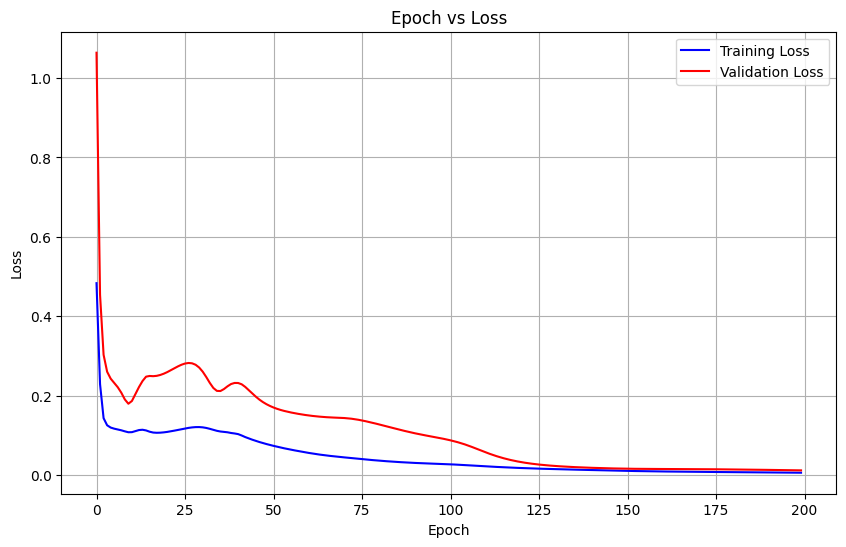

Testing Loss:  0.005561872301037586


In [ ]:
# See if model works
test_rnn = create_model(1e-3, 100) #0.001 LR, 10 hidden units, 100 epochs
epoch_loss_dictionary = train_model(test_rnn, 200, mean_squared_error_func, mean_squared_error_derivative_func)
score = test_model(test_rnn, mean_squared_error_func)
plot_losses_vs_epochs(epoch_loss_dictionary)
print("Testing Loss: ", score)


In [ ]:
#Grid search paramter tuning
learning_rates = [1e-4, 1e-3, 1e-2]
hidden_units = [10, 50, 100]
epochs_list = [50, 100, 200]

best_hyperparameters = {}
best_score = float('inf')

for lr in learning_rates:
    for hidden in hidden_units:
        for epochs in epochs_list:
            rnn = create_model(lr, hidden)
            print(f"Training with learning_rate={lr}, hidden_units={hidden}, epochs={epochs}")
            epoch_loss_dictionary = train_model(rnn, epochs, mean_squared_error_func, mean_squared_error_derivative_func)
            score = test_model(rnn, mean_squared_error_func)
            print(f"Training Score (MSE) for this configuration: {epoch_loss_dictionary[list(epoch_loss_dictionary.keys())[-1]][0]}")
            print(f"Validation Score (MSE) for this configuration: {epoch_loss_dictionary[list(epoch_loss_dictionary.keys())[-1]][1]}")
            print(f"Test Score (MSE) for this configuration: {score}")

            if score < best_score:
                best_score = score
                best_hyperparameters = {'learning_rate': lr, 'hidden_units': hidden, 'epochs': epochs}
            plot_losses_vs_epochs(epoch_loss_dictionary)
            print(f"Current best score: {best_score}")

# Print the best hyperparameters
print(f"Best Hyperparameters: {best_hyperparameters}")
print(f"Best Score: {best_score}")
